# Bulk Watershed DEM Downloader.
By - Nick Lewis.\
Advisors - Joanmarie Del Vecchio, Chuck Bailey.

# Code begins here!

#### Below is a 'code cell'.  This is a block of text that Jupyter and Python use to perform tasks.

#### To run the following code cell and all code cells below, select the cell and press
# <p style="color: aqua;">Shift+Enter.</p>

In [1]:
# Import packages to our notebook.
# We must do this to use the functions contained inside the packages.
# Some functions have 'as' in the import call.  This is for less typing, and nothing else.
# Google any package name and 'docs' in order to find more detailed explanation of any one package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import geopandas as gpd
import xdem
import os
import rasterio as rio
from rasterio.plot import show
import glob
from concurrent.futures import ThreadPoolExecutor
import requests
import shapely
from tqdm import tqdm
import json
from shapely.geometry import shape
from rasterio.mask import mask
from rasterio.crs import CRS
import rioxarray as rxr
from shapely import wkt
from pyproj import Proj, transform

#### Below is a code cell containing our **Constant** Variables, which you may change as you see fit for your particular analyses.

#### Below are 
- Integers
- Lists (denoted by square brackets at the beginning and end, separated by commas [a, b, c, d])
- Strings (contained within quotes 'Like this!')

In [2]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.4799, -78.467, 38.393, -80.2704] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_data' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

#### If you can't remember what a function does, call the help() function and pass the name of the function you are wondering about inside the colons.

# First,
#### We download a DEM of the user selected area.

Directory "/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_data" already exists.
Querying API...
URL passed, now waiting for file to write.
File Written.
Plotting...


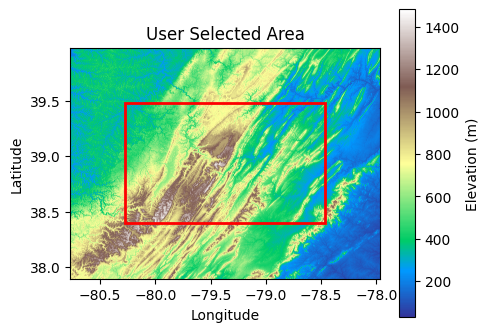

In [3]:
# Downloader
def downloader(bounds:list = BOUNDS, api_key:str = API_KEY, dem_dataset:str = DEM_DATASET, proj_title:str = PROJ_TITLE, path:str = PATH, buffer = True): # To call a function, we have to define it first.
    """
    This function takes in the user-defined constants and creates a directory.  It then places a geotiff in the directory.

    args: Bounds (list), api_key (str), dem_dataset (str), proj_title (str).

    returns: None.
    """

    # First, we make our directory for project files.
    try:
        os.mkdir(path = f'{path}/{proj_title}')
        print(f'Directory "{path}/{proj_title}" created successfully.') # Tries to make the directory for project files.
        proj_dir = f'{path}/{proj_title}'
    except FileExistsError:
        print(f'Directory "{path}/{proj_title}" already exists.') # If it doesnt work, it'll tell you!
        proj_dir = f'{path}/{proj_title}'
    except Exception as e:
        print(f'An error occurred: {e}')

    # Now to download our dem.
    dic = dict(zip(['north', 'east', 'south', 'west'], bounds)) # Makes a dictionary to let us more easily acess our bounds.
    if buffer == True:
        url = f'https://portal.opentopography.org/API/usgsdem?datasetName={dem_dataset}&south={dic["south"]-0.5}&north={dic["north"]+0.5}&west={dic["west"]-0.5}\
&east={dic["east"]+0.5}&outputFormat=GTiff&API_Key={api_key}' # Creates our URL so we can download.
    else:
        url = url = f'https://portal.opentopography.org/API/usgsdem?datasetName={dem_dataset}&south={dic["south"]}&north={dic["north"]}&west={dic["west"]}\
&east={dic["east"]}&outputFormat=GTiff&API_Key={api_key}' # Creates our URL so we can download.  BE WARNED! If buffer is false, there will be issues with the watershed DEMs.
    print('Querying API...')
    response = requests.get(url) # Saves what the URL spit back at us
    print('URL passed, now waiting for file to write.')
    with open(f'{proj_dir}/gtiff.tiff', 'wb') as file:
        file.write(response.content) # Writes the response to our project file
    print('File Written.')

    # Plotting
    print('Plotting...')
    fig, ax = plt.subplots(figsize=(5,5)) # Creates our figure object.
    ax.set_title('User Selected Area')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    with rio.open(f'{path}/{proj_title}/gtiff.tiff') as src: # Add in the basemap.
        basemap = show(src, cmap='terrain', ax=ax)
    im = basemap.get_images()[0]
    fig.colorbar(im, ax=ax, label='Elevation (m)', location='right', shrink=0.8) # Add colorbar
    bbox = patches.Rectangle((bounds[1],bounds[2]), width=(bounds[3]-bounds[1]), height=(bounds[0]-bounds[2]), linewidth=2, edgecolor='r', facecolor='none') # Add in bounding box from user.
    ax.add_patch(bbox)

    plt.show()
    plt.close()

downloader(buffer = True) # Here, we call the function.

# Next,
#### We will clip out each watershed in your selected area.

In [4]:
# Wshed Clipper
def wshed_clipper(mode, proj_title = PROJ_TITLE, bounds = BOUNDS, path = PATH):
    """
    Creates seperate DEMs for each watershed in the user's selected bounds.  Places in their own folder within user's project directory.

    args: proj_title (str), bounds (list), path (current working directory).

    returns: None.
    """
    print('Loading data...')

    #url for 12-digit HUCs is ../MapServer/6/
    #url = 'https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/7/query?'   #14-Digit HUC
    # url = 'https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/6/query?'   #12-Digit HUC
    # url = 'https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/6/query?'   #12-Digit HUC
    url = 'https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/5/query?'   #10-Digit HUC

    user_AOI = f'{bounds[3]}, {bounds[2]}, {bounds[1]}, {bounds[0]}'

    #the parameters here will query the map server for the appropriate HU boundary
    params = dict(geometry=user_AOI,geometryType='esriGeometryEnvelope',inSR='4326',
                spatialRel='esriSpatialRelIntersects',f='geojson')

    #Execute REST API call.  
    try:
        r = requests.get(url,params=params)
    except:
        print('Error with Service Call. This could mean that there is no hydrologic unit polygon where you selected.')

    #load API JSON output into a variable
    wbd_geojson = json.loads(r.content)
    print(wbd_geojson)   


    features = wbd_geojson['features']
    geometries = [shape(feature['geometry']) for feature in features]
    properties = [feature['properties']['name'] for feature in features]

    w_gdf_temp = pd.DataFrame({'Name': properties, 'geometry0' : geometries})
    gdf = gpd.GeoDataFrame(w_gdf_temp, geometry=w_gdf_temp['geometry0'], crs="EPSG:4326")
    
    clipped = gpd.GeoDataFrame(gdf.cx[bounds[3]:bounds[1], bounds[2]:bounds[0]]) # Clip it to the user's bounds.

    # Now that we have a GDF (GeoDataFrame) with the user's chosen watersheds and the larger dem, lets export DEMs of each watershed.
    try:
        os.mkdir(path = f'{path}/{proj_title}/wshed_dems') # Makes a directory to store these new dems.
        print(f'Directory "{path}/{proj_title}/wshed_dems" created successfully.') # Tries to make the directory for project files.
    except FileExistsError:
        print(f'Directory "{path}/{proj_title}/wshed_dems" already exists.') # If it doesnt work, it'll tell you!
    except Exception as e:
        print(f'An error occurred: {e}')
    
    # We have our directory, lets populate it.
    print('Writing new DEMs...')
    with rio.open(f'{path}/{proj_title}/gtiff.tiff') as src: # Loads in our larger df.
        total_tasks=len(clipped)
        with tqdm(total=total_tasks, desc='Progress') as pbar: # This is for the fancy progress bar.
            for name_orig in clipped['Name'].unique():
                name = name_orig.replace(' ', '_')
                if mode == 'shape':
                    geom = (clipped.loc[clipped['Name']==name_orig].geometry)
                elif mode == 'bounds':
                    geom = (clipped.loc[clipped['Name']==name_orig].geometry)
                    geom = shapely.geometry.box(float(geom.bounds['minx'].iloc[0]), float(geom.bounds['miny'].iloc[0]), float(geom.bounds['maxx'].iloc[0]), float(geom.bounds['maxy'].iloc[0]))
                else:
                    print('Please select mode ("shape" or "bounds")')
                # print(f'Geom is {geom}')

                out_image, out_transform = mask(src, [geom], crop=True) # Clips the DEM to our watershed's shape.  Sets nodata value to LSDTopyTools standard.

                # Below is metadata stuff, dont stress about this.
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                    })

                out_path = f'{path}/{proj_title}/wshed_dems/{name}.tiff' # Create a pathname.
                with rio.open(out_path, "w", **out_meta) as file:
                    file.write(out_image) # Write to file.
                pbar.update(1)
    

# Call our function, let it do the work.           
wshed_clipper(mode = 'bounds')

Loading data...
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-78.47745809961854, 38.515891264921386], [-78.4795947991157, 38.516075435880644], [-78.48044404123247, 38.51562678007558], [-78.48140003554435, 38.515530764294326], [-78.48251042510074, 38.515664357239785], [-78.48312849745726, 38.515474793453414], [-78.48377112526207, 38.51497371644683], [-78.48453469055862, 38.51442849319256], [-78.4852587425591, 38.51414117589387], [-78.48592371415995, 38.51385111264882], [-78.4862632809306, 38.513507687828216], [-78.48647244376305, 38.51262315468553], [-78.48720535944042, 38.511236563645], [-78.4886114429473, 38.511032483422966], [-78.48951795086683, 38.510640608017795], [-78.4904052788567, 38.51037090784171], [-78.49106102116635, 38.51034683186323], [-78.49156030929282, 38.51054362046933], [-78.49193000196485, 38.5106091514141], [-78.49231992200212, 38.51052994855831], [-78.4928750386269, 38.50997738467925], [-78.4931727

Progress: 100%|██████████| 62/62 [00:07<00:00,  8.83it/s]


In [5]:
# Relief & LSHT toolbox
def map_relief(dem_dir=f'{PATH}/{PROJ_TITLE}/wshed_dems'):
    """
    Takes DEMs of watersheds and produces TRI (Terrain ruggedness index, an SLRM) for each DEM.  Saves to own folder.

    args: dem_dir (path to wshed DEMs folder).

    returns: None.
    """
    # Glob a list of paths to the DEMs.
    path_list = glob.glob(f'{dem_dir}/*.tiff')
 
    try:
        os.mkdir(f'{PATH}/{PROJ_TITLE}/tri_pngs')
        print(f'Directory "{PATH}/{PROJ_TITLE}/tri_pngs" made sucessfully.')
    except FileExistsError:
        print(f'Directory "{PATH}/{PROJ_TITLE}/tri_pngs" Exists')
        pass
    except Exception as e:
        print(f'An error occured: {e}')
    print('Saving figures...')
    with tqdm(total=len(path_list), desc='Progress') as pbar:
        for path in path_list:
            tri = xdem.DEM(path).terrain_ruggedness_index()
            plt.ioff()
            fig, ax = plt.subplots(dpi=250)
            _ = tri.plot(cmap='magma', ax=ax, cbar_title='Relief (m)')
            name = path.split(sep='/')[-1][:-5]
            name_no_und = name.replace('_',' ')
            ax.set_title(f'{name_no_und} Terrain Ruggedness Index')
            ax.set_ylabel('Latitude (°)')
            ax.set_xlabel('Longitude (°)')
            fig.tight_layout()
            plt.savefig(f'{PATH}/{PROJ_TITLE}/tri_pngs/{name}_TRI.png')
            plt.close()
            pbar.update(1)

map_relief()

Directory "/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_data/tri_pngs" made sucessfully.
Saving figures...


Progress: 100%|██████████| 62/62 [01:09<00:00,  1.12s/it]


In [6]:
# reproj
from rasterio.crs import CRS
import rioxarray as rxr
import sys

def reproject(dem_path):
    crs = CRS.from_epsg(2283)
    dem = rxr.open_rasterio(dem_path)
    reprojected_dem = dem.rio.reproject(dst_crs=crs)
    dem_name = dem_path.split(sep='/')[-1][0:-5]
    reprojected_dem.rio.to_raster(f'{PATH}/{PROJ_TITLE}/reproj/{dem_name}_reproj.tiff')

try:
    os.mkdir(f'{PATH}/{PROJ_TITLE}/reproj')
except FileExistsError:
    print('Directory exists')
paths = glob.glob(f'{PATH}/{PROJ_TITLE}/wshed_dems/*.tiff')
with ThreadPoolExecutor() as executor:
    executor.map(reproject, paths)